In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import defaultdict

In [102]:
with open('models/model-bed5-away-head-foot.pkl') as f:
    model = pickle.load(f)

In [15]:
with open('packets/packets-bed5-test-1483901878041.pkl') as f:
    packets = pickle.load(f)

In [114]:
print model['access_points']
print len(model['access_points'])

['9c:1c:12:e3:da:42', '9c:1c:12:e3:da:41', 'd8:c7:c8:47:35:00', 'd8:c7:c8:47:39:62', 'd8:c7:c8:47:39:61', 'd8:c7:c8:47:39:60', 'd8:c7:c8:40:d3:42', 'd8:c7:c8:40:d3:40', '9c:1c:12:e3:da:40', 'd8:c7:c8:47:36:40', 'd8:c7:c8:43:13:22', 'd8:c7:c8:43:13:21', 'd8:c7:c8:43:13:20', 'd8:c7:c8:40:d3:41']
14


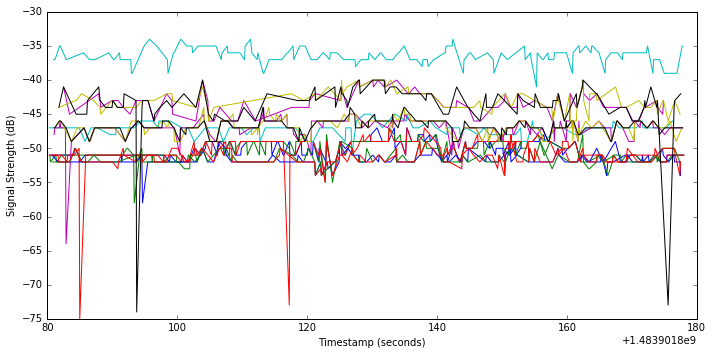

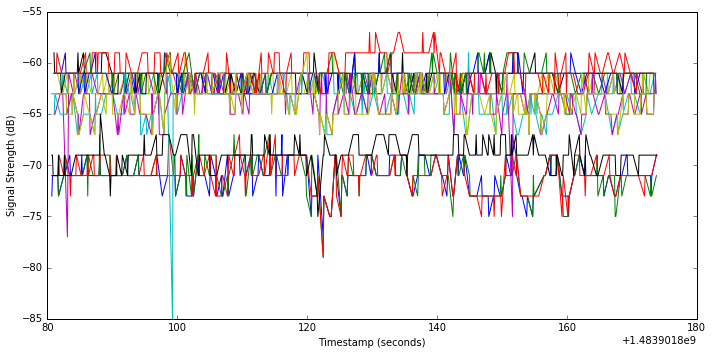

In [105]:
def plot(source, filename):
    rssis = defaultdict(list)
    times = defaultdict(list)
    for packet in filter(lambda p: p.source == source, sorted(packets, key=lambda p: p.time)):
        rssis[packet.addr2].append(packet.signal_rssi)
        times[packet.addr2].append(packet.time)
    plt.figure(figsize=(10, 5))
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Signal Strength (dB)')
    for ap in rssis.keys():
        if ap in model['access_points']:
            plt.plot(times[ap], rssis[ap], '-')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot('a', 'fig_eval1_signals_a.pdf')
plot('b', 'fig_eval1_signals_b.pdf')

invalid value encountered in double_scalars


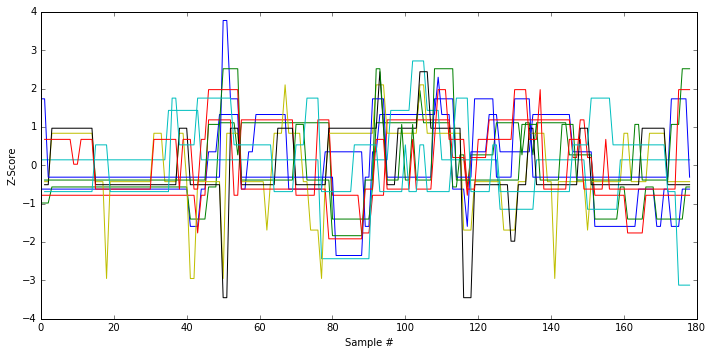

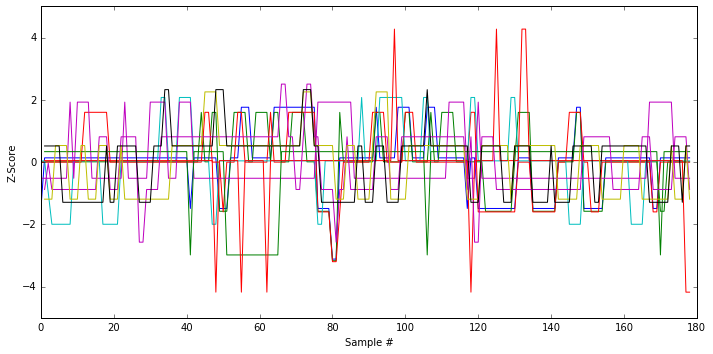

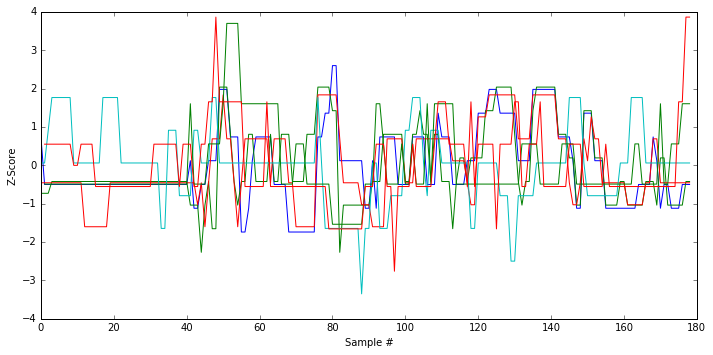

In [106]:
from sample_stream import SampleStreamPair

def plot(index, filename):
    samples = []
    ss = SampleStreamPair(samples.append)
    for packet in packets:
        ss.add_packet(packet, packet.source)

    rssis = defaultdict(list)
    times = defaultdict(list)
    ss_time = 0
    for sample in samples:
        for addr, blah in sample.iteritems():
            rssis[addr].append(blah[index])
            times[addr].append(ss_time)
        ss_time += 1

    for rssi in rssis.itervalues():
        avg = float(sum(rssi)) / len(rssi)
        sd = np.std(rssi)
        for i in range(len(rssi)):
            rssi[i] -= avg
            rssi[i] /= sd

    plt.figure(figsize=(10, 5))

    plt.ylabel('Z-Score')
    plt.xlabel('Sample #')
    for ap in rssis.keys():
        if ap in model['access_points']:
            plt.plot(times[ap], rssis[ap], '-')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot(0, 'fig_eval1_samples_a.pdf')
plot(1, 'fig_eval1_samples_b.pdf')
plot(2, 'fig_eval1_samples_diff.pdf')

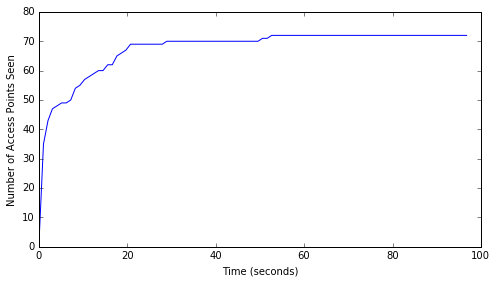

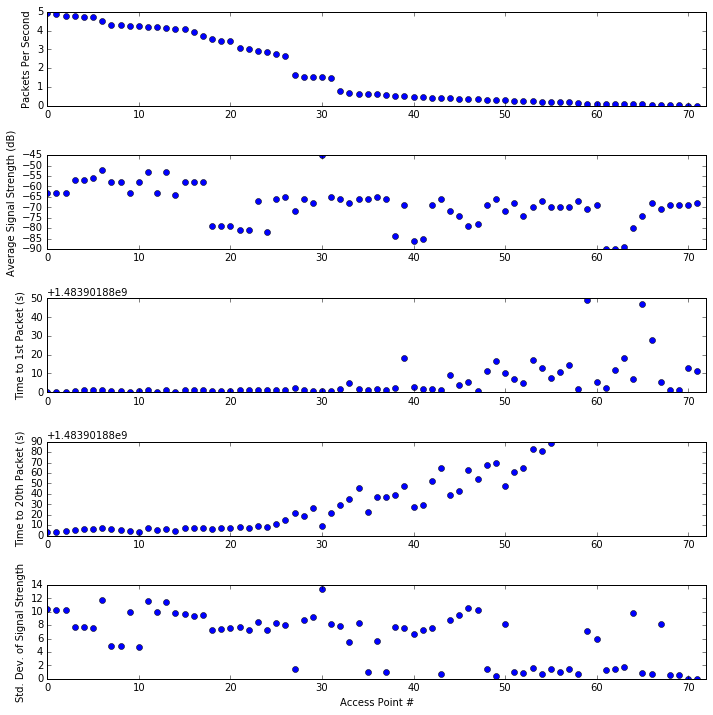

In [112]:
prev_time = 0
interval = 1
xs = []
ys = []
ap_counts = defaultdict(list)
for packet in packets:
    ap_counts[packet.addr2].append(packet)
    if packet.time > prev_time + interval:
        xs.append(packet.time)
        ys.append(len(ap_counts.keys()))
        prev_time = packet.time
xs = [x - xs[0] for x in xs]
    
plt.figure(figsize=(7, 4))
plt.plot(xs, ys)
# plt.title('Number of detected access points vs. time')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Access Points Seen')
plt.tight_layout()
plt.savefig('fig_eval1_ap_count.pdf')
plt.show()

total_time = packets[-1].time - packets[0].time

fig, axes = plt.subplots(nrows=5, figsize=(10, 10))
for ax in axes:
    ax.set_xlim((0, len(ap_counts.keys())))

sorted_ap_counts = sorted(ap_counts.values(), key=len, reverse=True)
axes[0].plot(map(lambda l: len(l) / total_time, sorted_ap_counts), 'o')
axes[0].set_ylabel('Packets Per Second')
axes[1].plot(map(lambda l: sum(map(lambda p: p.signal_rssi, l)) / len(l), sorted_ap_counts), 'o')
axes[1].set_ylabel('Average Signal Strength (dB)')
axes[2].plot(map(lambda l: l[0].time, sorted_ap_counts), 'o')
axes[2].set_ylabel('Time to 1st Packet (s)')
axes[3].plot(map(lambda l: l[19].time, filter(lambda l: len(l) >= 20, sorted_ap_counts)), 'o')
axes[3].set_ylabel('Time to 20th Packet (s)')
axes[4].plot(map(lambda l: np.std(map(lambda p: p.signal_rssi, l)), sorted_ap_counts), 'o')
axes[4].set_ylabel('Std. Dev. of Signal Strength')
plt.xlabel('Access Point #')
plt.tight_layout()
plt.savefig('fig_eval1_ap_stats.pdf')
plt.show()

threshold_packets_per_second = 1.0
filtered_aps = [addr
                for addr, ap_packets in ap_counts.iteritems()
                if len(ap_packets) / total_time > threshold_packets_per_second]

In [28]:
with open('data/training-data-bed5-away-head-foot.pkl') as f:
    training_data = pickle.load(f)

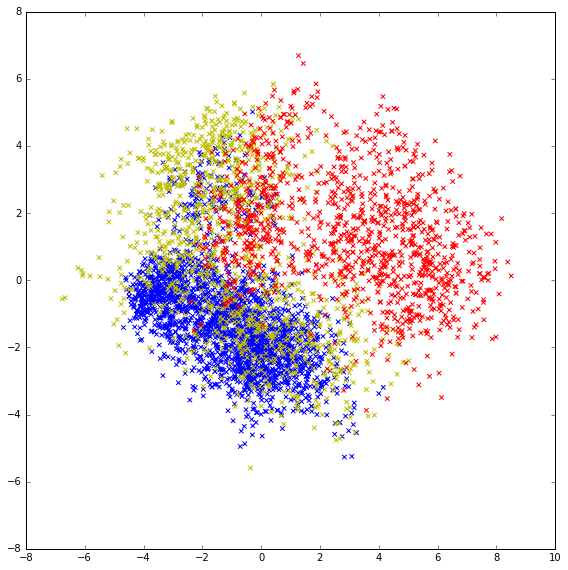

In [94]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


pca_model = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy='median', axis=0)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=30)),
    ('select', SelectKBest(f_classif, k=2)),
])

X_pca = pca_model.fit_transform(training_data['xs'], training_data['ys'])

# Randomly perturb points so they aren't overlapping
# for x in X_pca:
#     for i in range(len(x)):
#         x[i] += random.random() - 0.5

plot_xs = [i[0] for i in X_pca]
plot_ys = [i[1] for i in X_pca]
# plot_zs = [i[2] for i in X_pca]
colors = ['b', 'y', 'r', 'g']
plot_colors = [colors[i] for i in training_data['ys']]

fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.scatter(plot_xs, plot_ys, c=plot_colors, marker='x')

# ax2 = fig.add_subplot(122)
# ax2.scatter(plot_xs, plot_ys, c=plot_colors, marker='o')

plt.tight_layout()
plt.savefig('fig_eval1_pca.pdf')
plt.show()

Loading model models/model-bed5-away-head-foot-v2.pkl...
Loading packets...
Running classifier...
Done.
Number of predictions: 187
Accuracy: 0.834


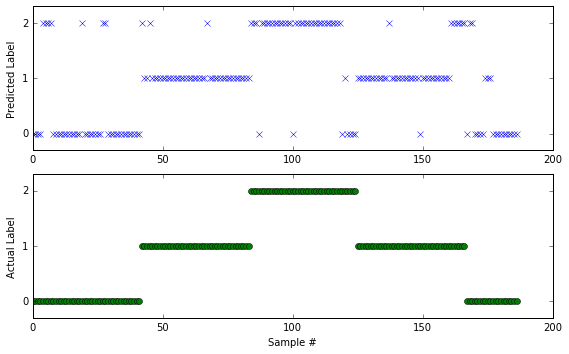

In [113]:
from classify_packets import classify_packets

model_filename = 'models/model-bed5-away-head-foot-v2.pkl'
packets_filename = 'packets/packets-bed5-test-1483901878041.pkl'

predictions = classify_packets(model_filename, packets_filename, print_results=False)
actual = [0, 0, 1, 1, 2, 2, 1, 1, 0]

# Compute accuracy
correct_count = 0
predicted = 0
votes = []
actual_array = []
print 'Number of predictions: %d' % len(predictions)
for i in range(len(predictions)):
    index = int(float(i) / len(predictions) * len(actual))
    predicted = predictions[i]
    votes.append(predicted)
    actual_array.append(actual[index])
    if predicted == actual[index]:
        correct_count += 1
        
print 'Accuracy: %.3f' % (float(correct_count) / len(predictions))

fig, axes = plt.subplots(nrows=2, figsize=(8, 5))
axes[0].plot(predictions, 'x')
axes[0].set_ylim(-0.3, 2.3)
axes[0].set_ylabel('Predicted Label')
axes[0].set_yticks([0, 1, 2])
axes[1].plot(actual_array, 'o', c='green')
axes[1].set_ylim(-0.3, 2.3)
axes[1].set_ylabel('Actual Label')
axes[1].set_yticks([0, 1, 2])
plt.xlabel('Sample #')
plt.tight_layout()
plt.savefig('fig_eval1_predict.pdf')
plt.show()